<a href="https://colab.research.google.com/github/RewinaB/peopleanalytics-regression-book/blob/master/Regularization_synthetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


---

# Regularization: Penalized regression

Regularization force the learning algorithm to build a less complex model . In practice, that often leads to slightly higher bias but significantly reduces the variance. The most common penalized regression models are:

1. Ridge regression
2. Lasso regression
3. Elastic Net regression

In this notebook we will explore the three methods and compare their results with a multiple liear regression model applied to our synthetic data generated from the following  true model f(x)

$$y =f(x)= x + 2x^2- 3 x^3 + \epsilon$$

The target variable is **y** and the features are 5 polynomial features of **X**. Namely, $X_1= X$, $X_2= X^2$, $X_3= X^3$, etc.


First we need to import the libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()  #if you want to use seaborn themes with matplotlib functions
import warnings
warnings.filterwarnings('ignore')

In [2]:
rand_state= 1000

In [3]:
df=pd.read_csv('https://raw.githubusercontent.com/PJalgotrader/Machine_Learning-USU/main/data/Regularization_synthetic.csv')

In [4]:
df.head()

,X1,X2,X3,X4,X5,y
0,1.668068,2.782452,4.641320,7.742038,12.914249,-3.901562
1,0.925862,0.857220,0.793667,0.734826,0.680348,-0.384578
2,1.057997,1.119357,1.184276,1.252960,1.325628,12.493677
3,-0.920339,0.847024,-0.779549,0.717449,-0.660297,12.237389
4,1.299748,1.689346,2.195725,2.853890,3.709339,-3.772851


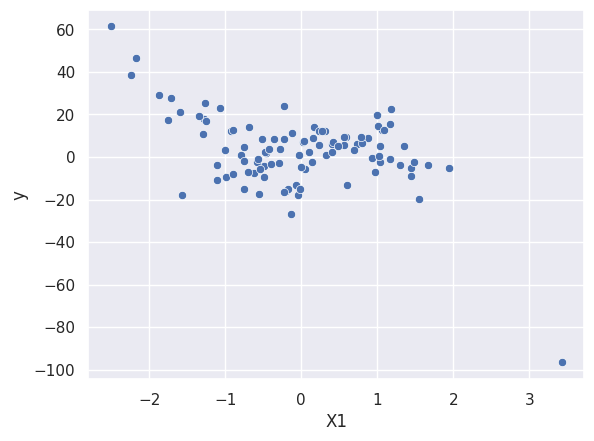

In [5]:
sns.scatterplot(x='X1', y='y', data=df)
plt.show()

**important**: we need to normalize the features before training the models. Computational effiient for lasso and elastic net. Ridge doesnt matter


In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
scaler=StandardScaler()
df_sc= scaler.fit_transform(df)

In [8]:
df_sc.shape

(100, 6)

In [9]:
df_sc[:2]

array([[ 1.68559489,  1.10379599,  0.93969261,  0.28529469,  0.20893775,
        -0.41160092],
       [ 0.95551657, -0.1126954 ,  0.15582326, -0.19468946, -0.0400858 ,
        -0.20670883]])

In [10]:
df_sc = pd.DataFrame(df_sc, columns=df.columns)
df_sc.head()

,X1,X2,X3,X4,X5,y
0,1.685595,1.103796,0.939693,0.285295,0.208938,-0.411601
1,0.955517,-0.112695,0.155823,-0.194689,-0.040086,-0.206709
2,1.085492,0.052941,0.235401,-0.159198,-0.026951,0.543551
3,-0.860516,-0.119138,-0.164683,-0.195880,-0.067375,0.528621
4,1.323294,0.413098,0.441460,-0.049537,0.021570,-0.404102


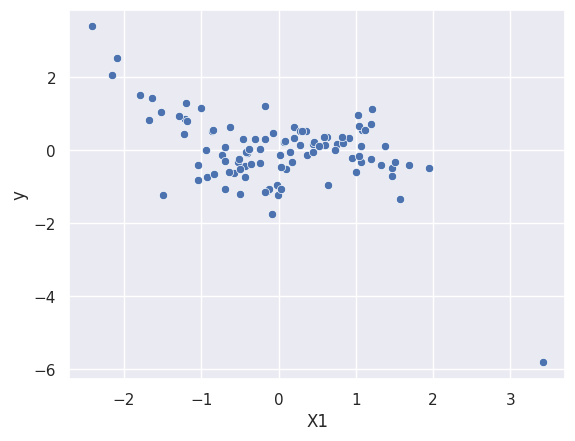

In [11]:
sns.scatterplot(x='X1', y='y', data=df_sc)
plt.show()

## Splitting the data

In [12]:
y = df_sc['y']
X = df_sc.drop('y', axis=1) # be careful, inplace= False

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
X_train.head()

,X1,X2,X3,X4,X5
37,1.464631,0.662152,0.606819,0.052327,0.073610
44,1.572794,0.870372,0.757779,0.153824,0.130178
55,0.275319,-0.619639,-0.003245,-0.244817,-0.053920
66,-0.493702,-0.464986,-0.039290,-0.238872,-0.054935
82,0.272588,-0.620456,-0.003337,-0.244827,-0.053921


Let's first run a linear regression (using statsmodels.api)  and see the results as a benchmark.

In [13]:
import statsmodels.api as sm

In [14]:
X_test_wc = sm.add_constant(X_test)
X_train_wc = sm.add_constant(X_train) #In linear regression, including a constant term allows the regression line to have an intercept with the y-axis, even if the predictors (features) have zero values.
#It essentially accounts for the baseline value of the target variable when all predictors are zero.

In [15]:
model = sm.OLS(y_train, X_train_wc).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.414
Method:                 Least Squares   F-statistic:                     12.17
Date:                Tue, 20 Feb 2024   Prob (F-statistic):           1.28e-08
Time:                        04:15:41   Log-Likelihood:                -65.981
No. Observations:                  80   AIC:                             144.0
Df Residuals:                      74   BIC:                             158.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0870      0.173      0.504      0.616      -0.257       0.431
X1             0.5370      0.199      2.705      0.008       0.141       0.933
X2             0.1037      0.302      0.343      0.732      -0.498       0.705
X3            -2.1339      0.839     -2.543      0.013      -3.806      -0.462
X4             0.2535      0.861      0.294      0.769      -1.463       1.970
X5             1.5933      1.669      0.954      0.343      -1.733       4.920
==============================================================================
Omnibus:                       11.757   Durbin-Watson:                   2.213
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               14.171
Skew:                          -0.701   Prob(JB):                     0.000837
Kurtosis:                       4.512   Cond. No.                         33.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

----

# A) Training the models

In this section we will train 4 different models:
1. Linear regression (model_linear)
2. Ridge regression (model_ridge)
3. Lasso regression (model_lasso)
4. Elastic Net regression (model_net)

In [16]:
from sklearn.linear_model import LinearRegression, Ridge,RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV

In [17]:
model_linear = LinearRegression()
model_ridge = Ridge(alpha=0)
model_lasso = Lasso(alpha=0)
model_net = ElasticNet(alpha=0)

In [18]:
y_hat_linear= model_linear.fit(X_train, y_train).predict(X_test)
y_hat_ridge = model_ridge.fit(X_train, y_train).predict(X_test)
y_hat_lasso = model_lasso.fit(X_train, y_train).predict(X_test)# here all alphas are set to 0,so all Y-hats are the same
y_hat_net   = model_net.fit(X_train, y_train).predict(X_test) #After fitting the model to the training data, the predict() method is used to generate predictions for the target variable using the testing data (X_test).
#These predictions are stored in the variable y_hat_linear.

In [19]:
df_predictions = pd.DataFrame({'y_test':y_test,
                               'y_hat_linear':y_hat_linear,
                               'y_hat_ridge':y_hat_ridge,
                               'y_hat_lasso':y_hat_lasso,
                               'y_hat_net':y_hat_net})
df_predictions.head()

,y_test,y_hat_linear,y_hat_ridge,y_hat_lasso,y_hat_net
88,1.307243,0.171067,0.171067,0.171067,0.171067
4,-0.404102,-0.079686,-0.079686,-0.079686,-0.079686
62,-1.055680,-0.180921,-0.180921,-0.180921,-0.180921
63,2.538916,2.344482,2.344482,2.344482,2.344482
48,1.144605,-0.078630,-0.078630,-0.078630,-0.078630


### coefficients

In [20]:
df.drop('y', axis=1, inplace=False).columns

Index(['X1', 'X2', 'X3', 'X4', 'X5'], dtype='object')

In [21]:
coefficients = pd.DataFrame({'Features':df.drop('y', axis=1, inplace=False).columns})
coefficients['model_lin']= model_linear.coef_
coefficients['model_ridge']= model_ridge.coef_
coefficients['model_lasso']= model_lasso.coef_
coefficients['model_net']= model_net.coef_
coefficients

,Features,model_lin,model_ridge,model_lasso,model_net
0,X1,0.537047,0.537047,0.537047,0.537047
1,X2,0.103655,0.103655,0.103655,0.103655
2,X3,-2.133872,-2.133872,-2.133872,-2.133872
3,X4,0.253492,0.253492,0.253492,0.253492
4,X5,1.593336,1.593336,1.593336,1.593336


Exercise: Why do you think if $\alpha = 0$, all the 4 model coefficients are the same? there is no penalization happening

----

### Performance in the test set

In [22]:
model_linear.score(X_test, y_test)

-0.5051758896584884

In [23]:
MSE_test_lin = np.mean(np.square(df_predictions['y_test'] - df_predictions['y_hat_linear']))
RMSE_test_lin = np.sqrt(MSE_test_lin)
np.round(RMSE_test_lin,3)

2.037

In [24]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate MSE
MSE_test_lin = mean_squared_error(df_predictions['y_test'], df_predictions['y_hat_linear'])

# Calculate RMSE
RMSE_test_lin = np.sqrt(MSE_test_lin)

# Round RMSE to three decimal places
rounded_RMSE = np.round(RMSE_test_lin, 3)
rounded_RMSE


2.037

In [25]:
model_ridge.score(X_test, y_test)

-0.5051758896588487

In [26]:
MSE_test_ridge = np.mean(np.square(df_predictions['y_test'] - df_predictions['y_hat_ridge']))
RMSE_test_ridge = np.sqrt(MSE_test_ridge)
np.round(RMSE_test_ridge,3)

2.037

In [27]:
model_lasso.score(X_test, y_test)

-0.5051758639724002

In [28]:
MSE_test_lasso = np.mean(np.square(df_predictions['y_test'] - df_predictions['y_hat_lasso']))
RMSE_test_lasso = np.sqrt(MSE_test_lasso)
np.round(RMSE_test_lasso,3)

2.037

In [29]:
model_net.score(X_test, y_test)

-0.5051758639724002

In [30]:
MSE_test_net = np.mean(np.square(df_predictions['y_test'] - df_predictions['y_hat_net']))
RMSE_test_net = np.sqrt(MSE_test_net)
np.round(RMSE_test_net,3)

2.037

-------------

### Plotting the regression coefficients vs alphas:

#### 1) Ridge regression coefficients vs alpha

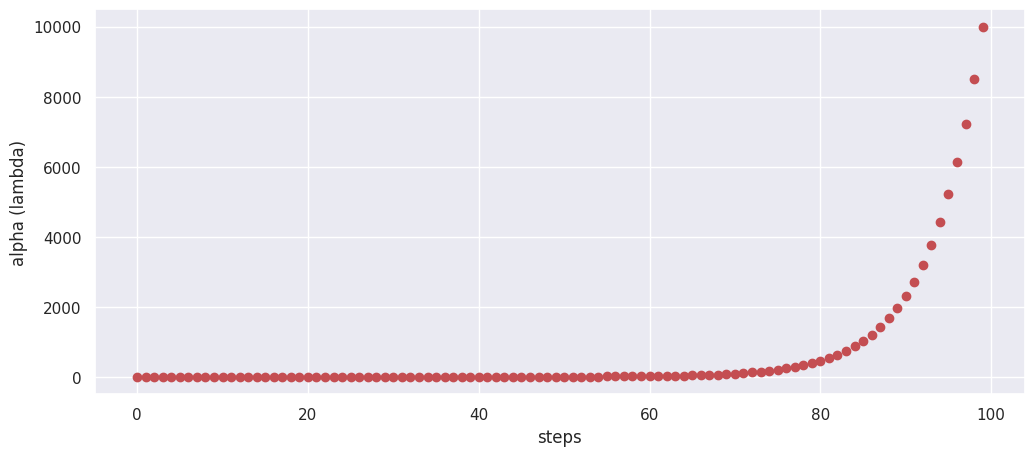

In [31]:
alpha_ridge = 10**np.linspace(-3,4,100)
plt.figure(figsize=(12,5))
plt.plot(alpha_ridge,'or' )
plt.xlabel('steps')
plt.ylabel('alpha (lambda)')
plt.show()

In [32]:
len(alpha_ridge)

100

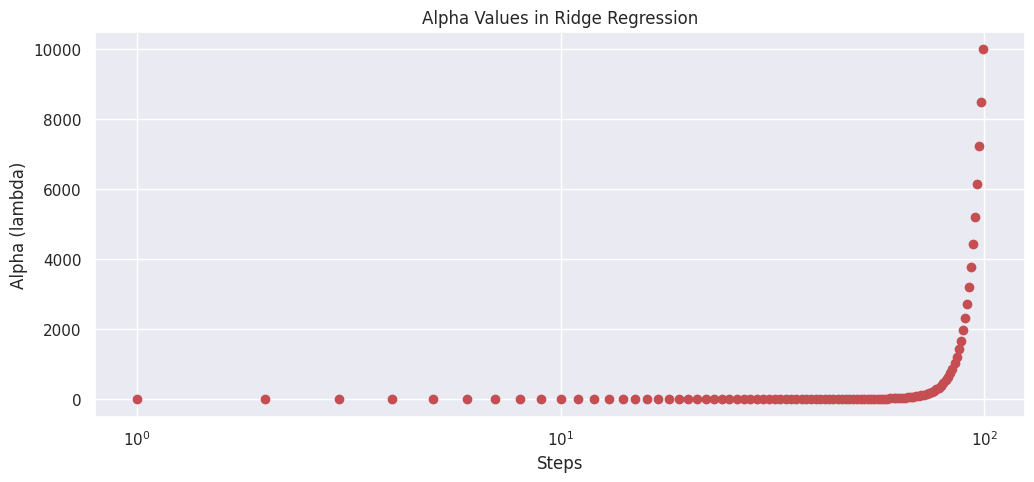

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Generate alpha values on a logarithmic scale
alpha_ridge = 10 ** np.linspace(-3, 4, 100)

# Plot alpha values against steps
plt.figure(figsize=(12, 5))
plt.plot(alpha_ridge, 'or')
plt.xscale('log')  # Set logarithmic scale for x-axis
plt.xlabel('Steps')
plt.ylabel('Alpha (lambda)')
plt.title('Alpha Values in Ridge Regression')
plt.grid(True)  # Add grid for better readability
plt.show()


In [34]:
ridge = Ridge()
coefs_ridge = []

for i in alpha_ridge:
    ridge.set_params(alpha = i)
    ridge.fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)

np.shape(coefs_ridge)

(100, 5)

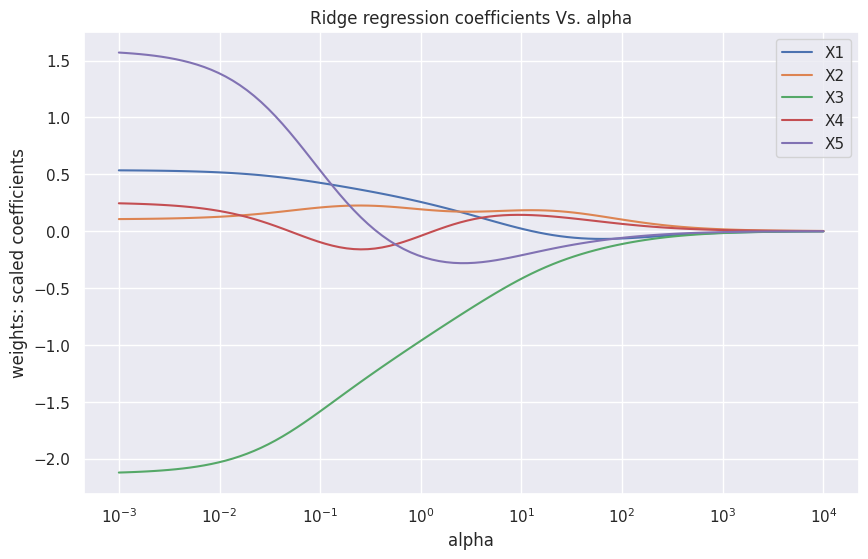

In [35]:
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.plot(alpha_ridge, coefs_ridge)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights: scaled coefficients')
plt.title('Ridge regression coefficients Vs. alpha')
plt.legend(df.drop('y',axis=1, inplace=False).columns)

plt.show()

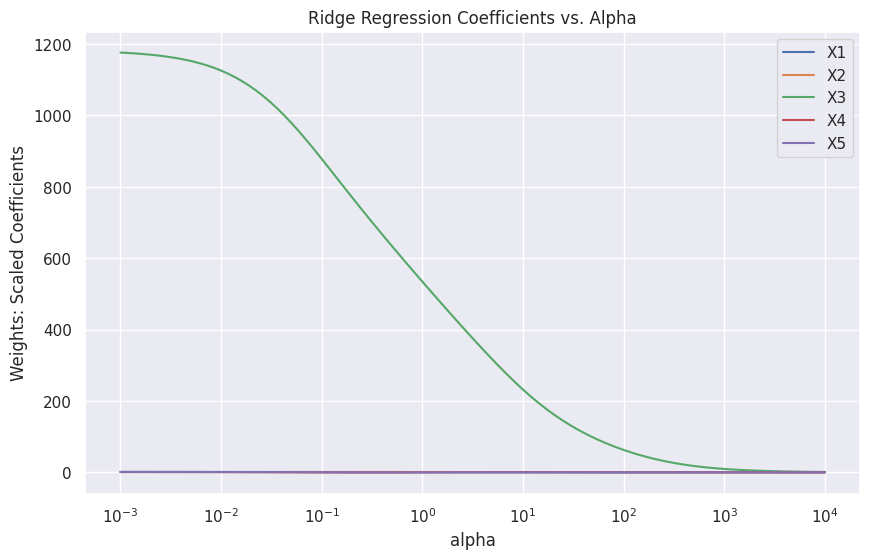

In [36]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Scaling the coefficients for better visualization
coefs_scaled = np.array(coefs_ridge) / np.array(coefs_ridge).max(axis=0)

# Plotting
ax.plot(alpha_ridge, coefs_scaled)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Weights: Scaled Coefficients')
plt.title('Ridge Regression Coefficients vs. Alpha')
plt.legend(df.drop('y', axis=1, inplace=False).columns)

plt.show()


---

#### 2) Lasso regression coefficients vs alpha

In [37]:
alpha_lasso = 10**np.linspace(-3,1,100)

In [38]:
lasso = Lasso()
coefs_lasso = []

for i in alpha_lasso:
    lasso.set_params(alpha = i)
    lasso.fit(X_train, y_train)
    coefs_lasso.append(lasso.coef_)

np.shape(coefs_lasso)

(100, 5)

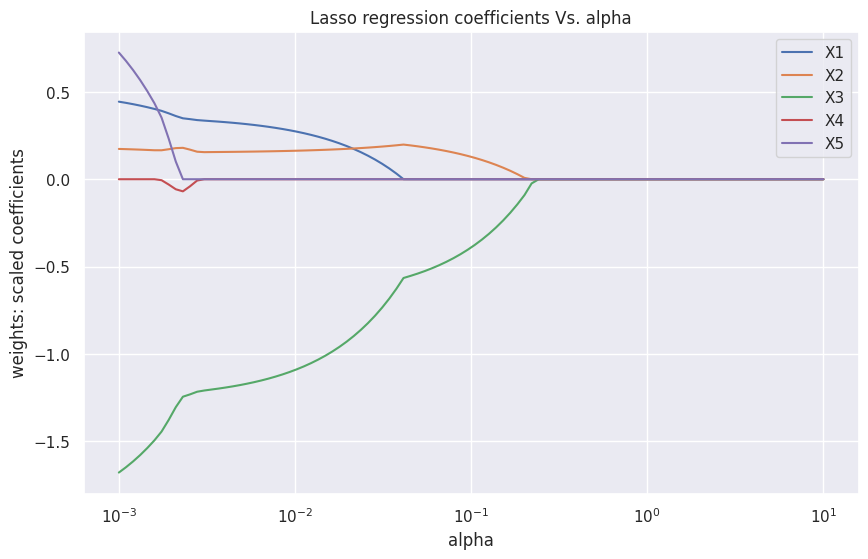

In [39]:
plt.figure(figsize=(10,6))
ax = plt.gca()
ax.plot(alpha_lasso, coefs_lasso)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights: scaled coefficients')
plt.title('Lasso regression coefficients Vs. alpha')
plt.legend(df.drop('y',axis=1, inplace=False).columns)

plt.show()

---

#### 3) Elastic Net regression coefficients vs alpha

In [40]:
alpha_elasticnet = 10**np.linspace(-3,1,100)

In [41]:
elasticnet = ElasticNet()
coefs_elasticnet = []

for i in alpha_elasticnet:
    elasticnet.set_params(alpha = i)
    elasticnet.fit(X_train, y_train)
    coefs_elasticnet.append(elasticnet.coef_)

np.shape(coefs_elasticnet)

(100, 5)

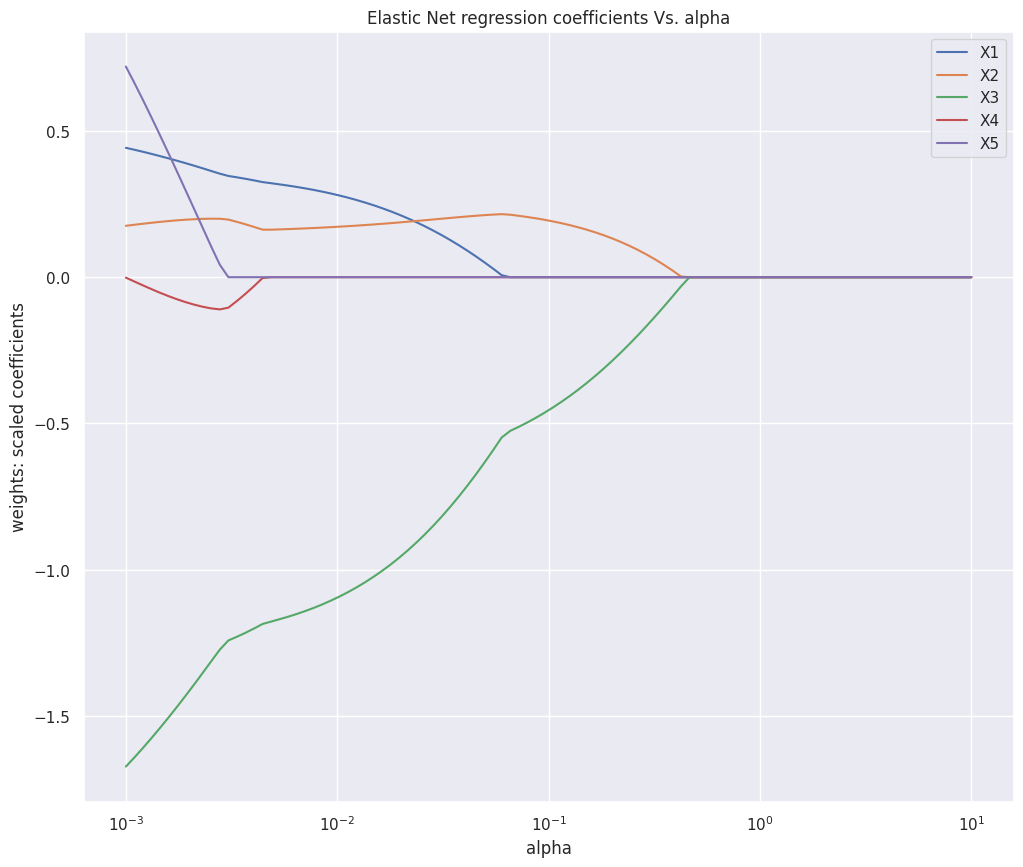

In [42]:
plt.figure(figsize=(12,10))
ax = plt.gca()
ax.plot(alpha_elasticnet, coefs_elasticnet)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights: scaled coefficients')
plt.title('Elastic Net regression coefficients Vs. alpha')
plt.legend(df.drop('y',axis=1, inplace=False).columns)

plt.show()

----

## Cross Validation

Let's use cross validation to find the optimal Lambdas (alphas) for different models.

#### 1) Optimal alpha for Ridge regression

In [43]:
ridgecv = RidgeCV(alphas=alpha_ridge)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

1.291549665014884

In [44]:
alpha_ridge_opt = ridgecv.alpha_

In [45]:
ridgecv.coef_

array([ 0.23326653,  0.18398615, -0.89894889, -0.00492102, -0.24987795])

----

#### 2) Optimal alpha for Lasso regression

In [46]:
lassocv = LassoCV(alphas=alpha_lasso)
lassocv.fit(X_train, y_train)
lassocv.alpha_

0.004862601580065354

In [47]:
alpha_lasso_opt = lassocv.alpha_

In [48]:
lassocv.coef_

array([ 0.31944719,  0.15721496, -1.17879735, -0.        ,  0.        ])

----

#### 3) Optimal alpha for Elastic Net regression

In [49]:
elasticnetcv = ElasticNetCV(alphas=alpha_elasticnet, l1_ratio=np.linspace(0.0, 1, 11))
elasticnetcv.fit(X_train, y_train)
elasticnetcv.alpha_

0.004862601580065354

In [50]:
elasticnetcv.l1_ratio_

0.9

In [51]:
alpha_elasticnet_opt = elasticnetcv.alpha_

In [52]:
elasticnetcv.coef_

array([ 0.31976495,  0.15827089, -1.17839143, -0.        ,  0.        ])

----

#### Refit the models!

***Exercise***: Now go back and refit the 3 models with the optimal alphas!
- compare the RMSE_test?
- were you able to beat the linear regression model?
- what do you conclude?

---
---
# PyCaret

1. **PyCaret**: https://pycaret.readthedocs.io/en/latest/index.html PyCaret3.0
2. **scikit-learn**: https://scikit-learn.org/stable/index.html
3. **PyCaret model containers** : https://github.com/pycaret/pycaret/tree/master/pycaret/containers/models

# Installation

Follow the steps here: https://pycaret.gitbook.io/docs/get-started/installation


In [56]:
#only if you want to run it in Google Colab:
# for this chapter, we can install the light version of PyCaret as below.

!pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.7/484.7 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.6 MB/s e

In [53]:

from pycaret.utils import version
version()

'3.2.0'

In [54]:
df.head()

,X1,X2,X3,X4,X5,y
0,1.668068,2.782452,4.641320,7.742038,12.914249,-3.901562
1,0.925862,0.857220,0.793667,0.734826,0.680348,-0.384578
2,1.057997,1.119357,1.184276,1.252960,1.325628,12.493677
3,-0.920339,0.847024,-0.779549,0.717449,-0.660297,12.237389
4,1.299748,1.689346,2.195725,2.853890,3.709339,-3.772851


In [55]:
from pycaret.regression import *

In [56]:
setup(df, target='y', session_id=1000, train_size=0.8, fold_strategy='kfold', fold=5,
      normalize=True, normalize_method='zscore')

,Description,Value
0,Session id,1000
1,Target,y
2,Target type,Regression
3,Original data shape,"(100, 6)"
4,Transformed data shape,"(100, 6)"
5,Transformed train set shape,"(80, 6)"
6,Transformed test set shape,"(20, 6)"
7,Numeric features,5
8,Preprocess,True
9,Imputation type,simple


In [57]:
models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


## Create and tune model

In [58]:
lr = create_model(estimator='lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.0868,69.3051,8.3250,0.0811,1.1554,2.2193
1,8.1472,138.2158,11.7565,-0.3866,1.0653,1.3712
2,10.9808,313.8018,17.7145,-0.0065,1.5855,0.7485
3,10.7973,199.8801,14.1379,-0.1573,1.2084,0.9093
4,5.4064,45.4753,6.7435,0.5687,1.0221,2.4226
Mean,8.4837,153.3356,11.7355,0.0199,1.2073,1.5342
Std,2.1505,96.7878,3.9515,0.3170,0.2001,0.6772


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [59]:
tuned_lr = tune_model(lr) # we really don't need to run this line. Why? bc its the same as above and no tuning/penalization has occured yet.

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.0868,69.3051,8.3250,0.0811,1.1554,2.2193
1,8.1472,138.2158,11.7565,-0.3866,1.0653,1.3712
2,10.9808,313.8018,17.7145,-0.0065,1.5855,0.7485
3,10.7973,199.8801,14.1379,-0.1573,1.2084,0.9093
4,5.4064,45.4753,6.7435,0.5687,1.0221,2.4226
Mean,8.4837,153.3356,11.7355,0.0199,1.2073,1.5342
Std,2.1505,96.7878,3.9515,0.3170,0.2001,0.6772


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 2 candidates, totalling 10 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


What is happening inside the tune_model? https://github.com/pycaret/pycaret/blob/master/pycaret/containers/models/regression.py

In [60]:
ridge = create_model(estimator='ridge')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.1222,71.5477,8.4586,0.0514,1.1987,2.0879
1,7.9911,125.7941,11.2158,-0.2620,0.9757,1.2352
2,8.0989,88.5367,9.4094,0.7160,1.4172,0.7952
3,10.9981,193.6841,13.9170,-0.1214,1.3644,0.9450
4,5.4602,48.5251,6.9660,0.5398,1.0812,2.1170
Mean,7.9341,105.6175,9.9934,0.1848,1.2075,1.4360
Std,1.7999,50.7442,2.3980,0.3793,0.1663,0.5623


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [61]:
tuned_ridge = tune_model(ridge)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.0379,73.2197,8.5569,0.0292,1.1548,1.6201
1,7.7002,108.6776,10.4249,-0.0903,0.9166,1.0669
2,8.8169,102.0127,10.1001,0.6728,1.2377,0.9376
3,11.0326,188.0557,13.7133,-0.0888,1.3676,0.9109
4,5.6968,50.9122,7.1353,0.5172,0.9083,1.6565
Mean,8.0569,104.5756,9.9861,0.2080,1.1170,1.2384
Std,1.7982,46.5946,2.2031,0.3227,0.1803,0.3309


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [62]:
lasso = create_model(estimator='lasso')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.8909,72.4029,8.5090,0.0401,1.0412,1.4003
1,8.2973,120.1616,10.9618,-0.2055,0.9738,1.1786
2,9.4402,113.3639,10.6472,0.6364,1.1718,1.0820
3,10.9375,189.1648,13.7537,-0.0952,1.2808,0.9071
4,5.9705,57.2171,7.5642,0.4574,0.7774,1.4978
Mean,8.3073,110.4621,10.2872,0.1666,1.0490,1.2132
Std,1.7702,46.0003,2.1531,0.3251,0.1722,0.2136


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [63]:
tuned_lasso = tune_model(lasso)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.8316,72.0065,8.4857,0.0453,0.9770,1.4211
1,8.3343,122.0966,11.0497,-0.2249,0.9314,1.2219
2,10.7243,146.2430,12.0931,0.5309,1.1476,1.1203
3,10.9097,184.5603,13.5853,-0.0686,1.1941,0.9278
4,6.0984,63.3412,7.9587,0.3993,0.7544,1.5010
Mean,8.5797,117.6495,10.6345,0.1364,1.0009,1.2384
Std,1.9647,45.4909,2.1347,0.2848,0.1581,0.2064


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [64]:
elasticnet = create_model(estimator='en')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.8438,72.7915,8.5318,0.0349,1.0098,1.2854
1,7.7426,110.7061,10.5217,-0.1106,0.9257,1.0901
2,10.1275,128.6768,11.3436,0.5873,1.2022,1.0975
3,11.0100,185.7460,13.6289,-0.0754,1.2077,0.9298
4,5.8872,51.9317,7.2064,0.5075,0.8650,1.4571
Mean,8.3222,109.9704,10.2465,0.1887,1.0421,1.1720
Std,1.9460,46.5686,2.2317,0.2978,0.1407,0.1817


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [65]:
tuned_elasticnet = tune_model(elasticnet)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.0951,70.4418,8.3930,0.0661,1.2139,2.0129
1,7.8995,119.6057,10.9364,-0.1999,0.9567,1.2370
2,7.8007,86.7497,9.3140,0.7218,1.3968,0.8120
3,10.9461,191.9947,13.8562,-0.1116,1.4087,0.9242
4,5.3735,48.2528,6.9464,0.5424,1.0369,2.0800
Mean,7.8230,103.4089,9.8892,0.2037,1.2026,1.4132
Std,1.8050,50.0327,2.3691,0.3645,0.1834,0.5359


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [66]:
compare_models([lr,tuned_lr, lasso, tuned_lasso, ridge, tuned_ridge, elasticnet, tuned_elasticnet])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
5,Ridge Regression,8.0569,104.5756,9.9861,0.2080,1.1170,1.2384,0.0300
7,Elastic Net,7.8230,103.4089,9.8892,0.2037,1.2026,1.4132,0.0240
6,Elastic Net,8.3222,109.9704,10.2465,0.1887,1.0421,1.1720,0.0340
4,Ridge Regression,7.9341,105.6175,9.9934,0.1848,1.2075,1.4360,0.0240
2,Lasso Regression,8.3073,110.4621,10.2872,0.1666,1.0490,1.2132,0.0260
3,Lasso Regression,8.3073,110.4621,10.2872,0.1666,1.0490,1.2132,0.0300
0,Linear Regression,8.4837,153.3356,11.7355,0.0199,1.2073,1.5342,0.0280
1,Linear Regression,8.4837,153.3356,11.7355,0.0199,1.2073,1.5342,0.0300


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

Ridge(alpha=8.65, random_state=1000)

The best model is tuned ridge!

Bonus question: Why we were not able to get the same answer with PyCaret? remember, our best model was ElasticNet.

## Plot model

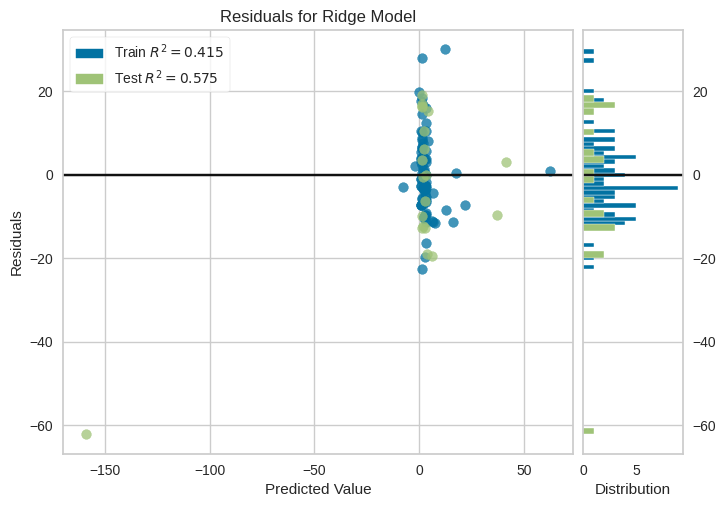

In [67]:
plot_model(tuned_ridge,plot='residuals')

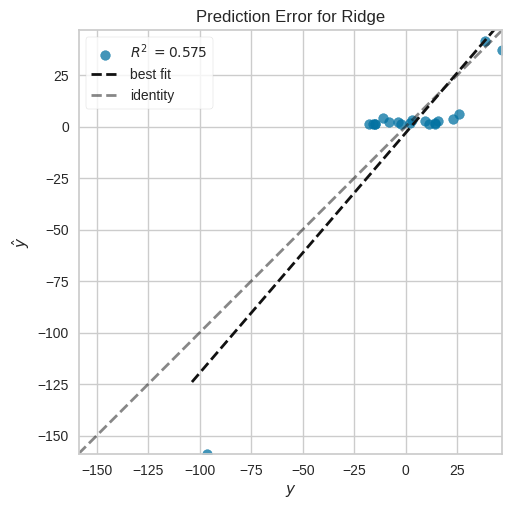

In [68]:
plot_model(tuned_ridge,plot='error' )

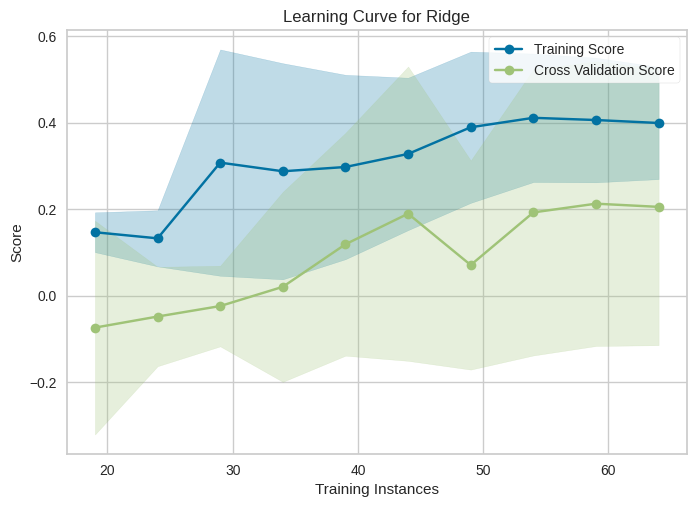

In [69]:
plot_model(tuned_ridge,plot='learning')

## Predict model

In [70]:
pycaret_predictions = predict_model(tuned_ridge)
pycaret_predictions

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Ridge Regression,13.5817,344.9441,18.5727,0.5753,1.3192,0.8509


,X1,X2,X3,X4,X5,y,prediction_label
88,-1.270066,1.613067,-2.048701,2.601985e+00,-3.304691e+00,25.602488,6.237529
4,1.299748,1.689346,2.195725,2.853890e+00,3.709339e+00,-3.772851,2.264750
62,-0.176185,0.031041,-0.005469,9.635560e-04,-1.697640e-04,-14.957215,1.146233
63,-2.172674,4.720512,-10.256133,2.228323e+01,-4.841420e+01,46.744209,37.120049
48,-1.063891,1.131864,-1.204180,1.281116e+00,-1.362968e+00,22.810785,3.725569
85,1.169370,1.367426,1.599027,1.869854e+00,2.186551e+00,15.660195,2.904333
73,-1.109817,1.231695,-1.366956,1.517072e+00,-1.683673e+00,-10.956726,4.194131
84,-1.000759,1.001519,-1.002279,1.003040e+00,-1.003801e+00,3.248486,3.157096
39,-0.690765,0.477157,-0.329603,2.276786e-01,-1.572725e-01,14.289402,1.424382
47,-0.118042,0.013934,-0.001645,1.941540e-04,-2.290000e-05,11.126081,1.240201


----

###  Additional links:
1. Underfitting vs Overfitting: https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html#sphx-glr-auto-examples-model-selection-plot-underfitting-overfitting-py
2. From Linear Regression to Ridge Regression, the Lasso, and the Elastic Net: https://towardsdatascience.com/from-linear-regression-to-ridge-regression-the-lasso-and-the-elastic-net-4eaecaf5f7e6
3. Standardizing features in Python:https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
4. sklearn Ridge: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
5. sklearn RidgeCV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV
6. sklearn Lasso: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
7. skearn LassoCV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV
8. sklearn Elasticnet: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html
9. sklearn ElasticNetCV: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNetCV.html#sklearn.linear_model.ElasticNetCV
